In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import scipy
from scipy.optimize import fminbound

In [2]:
def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw


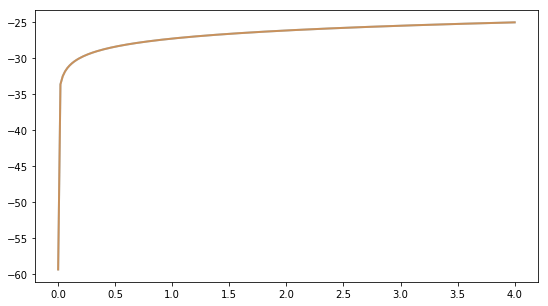

In [11]:
""" Problem 2 """

#Model Paramters
alpha = 0.4
beta = 0.96
mu = 0
s = 0.1

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

err1 = 1
w1 = 0.95 * grid
while err1 > 1e-4:
    wprime1 = bellman_operator(w1, grid, beta, np.log, lambda k: k**alpha, shocks)
    err1 = np.linalg.norm(wprime1-w1)
    w1 = wprime1 

err2 = 1
w2 = scipy.stats.lognorm.cdf(grid, 0.5) * grid
while err2 > 1e-4:
    wprime2 = bellman_operator(w2, grid, beta, np.log, lambda k: k**alpha, shocks)
    err2 = np.linalg.norm(wprime2-w2)
    w2 = wprime2 

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(grid, w1, lw=2, alpha=0.6)
ax.plot(grid, w2, lw=2, alpha=0.6)
plt.show()